In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("Realisierter_Stromverbrauch_201501010000_202311152359_Viertelstunde.csv", sep=";")
df.head()

,Datum,Anfang,Ende,Gesamt (Netzlast) [MWh] Originalauflösungen,Residuallast [MWh] Originalauflösungen,Pumpspeicher [MWh] Originalauflösungen
0,01.01.2015,00:00,00:15,11.210,"9.051,75",123
1,01.01.2015,00:15,00:30,"11.118,75","8.966,5","154,25"
2,01.01.2015,00:30,00:45,"11.144,75",8.976,"160,5"
3,01.01.2015,00:45,01:00,"11.126,75","8.961,5","163,75"
4,01.01.2015,01:00,01:15,"11.009,5",8.835,"87,5"


In [5]:
# Rename columns for convenience
df.columns = ["datum", "anfang", "ende", "gesamt", "residual", "pump"]

df.replace('-', pd.NA, inplace=True)
df.dropna(how = 'all', inplace=True, subset=['gesamt', 'residual', 'pump'])
df.tail()

,datum,anfang,ende,gesamt,residual,pump
311059,15.11.2023,04:45,05:00,"11.929,25","5.637,75","1.004,75"
311060,15.11.2023,05:00,05:15,12.289,"6.075,5","1.066,75"
311061,15.11.2023,05:15,05:30,"12.477,75",6.370,"1.056,5"
311062,15.11.2023,05:30,05:45,"12.774,25","6.721,75",888
311063,15.11.2023,05:45,06:00,13.142,<NA>,<NA>


In [4]:
# Replace "." with "" and then replace "," with "."
df[['gesamt', 'residual', 'pump']] = df[['gesamt', 'residual', 'pump']].apply(lambda x: x.str.replace('.', '', regex=False))
df[['gesamt', 'residual', 'pump']] = df[['gesamt', 'residual', 'pump']].apply(lambda x: x.str.replace(',', '.', regex=False))
df[['gesamt', 'residual', 'pump']] = df[['gesamt', 'residual', 'pump']].apply(pd.to_numeric)

In [5]:
# Merge date and time column and set that as the index
df["date_time"] = pd.to_datetime(df['datum'] + ' ' + df['ende'], format='%d.%m.%Y %H:%M')
df.set_index("date_time", inplace=True)

In [6]:
df_fill = df.copy()
n_rows = df_fill.shape[0]

for row_idx in np.where(df.isna())[0]:
    if ((row_idx-1) < 0) :
        df_fill.iloc[row_idx, 4] = df_fill.iloc[row_idx+1, 4]
    elif ((row_idx+1) == n_rows) :
        df_fill.iloc[row_idx, 4] = df_fill.iloc[row_idx-1, 4]
    else :
        df_fill.iloc[row_idx, 4] = (df_fill.iloc[row_idx-1, 4] + df_fill.iloc[row_idx+1, 4]) / 2

In [7]:
# df_fill[df_fill.index=="2020-03-29 02:00:00"]
# np.where(df_fill.index=="2020-03-29 02:00:00")

n = 183751
df_fill.iloc[n-1:n+2]

# missing data eg in 2020-03-29 02:00:00
# where entire hour is missing, and therefore the hourly aggregation is way too low ...

,datum,anfang,ende,gesamt,residual,pump
date_time,,,,,,
2020-03-29 01:45:00,29.03.2020,01:30,01:45,10340.25,4654.25,308.50
2020-03-29 02:00:00,29.03.2020,01:45,02:00,8442.75,2753.75,416.75
2020-03-29 03:15:00,29.03.2020,03:00,03:15,10220.50,4513.50,186.75


In [8]:
df_hourly = df_fill.loc[:, ['gesamt', 'residual', 'pump']].resample("1h", label="left").sum()
df_hourly.tail()

,gesamt,residual,pump
date_time,,,
2023-11-15 02:00:00,44858.25,19962.50,5461.00
2023-11-15 03:00:00,45144.75,19953.00,5236.25
2023-11-15 04:00:00,46019.50,20758.50,4949.00
2023-11-15 05:00:00,49470.25,24805.00,4016.00
2023-11-15 06:00:00,13142.00,6721.75,0.00


In [9]:
min_val = np.min(df_hourly["gesamt"])
print(f"min is {min_val}")
df_hourly[df_hourly["gesamt"]<10_000]

min is 7354.5


,gesamt,residual,pump
date_time,,,
2015-03-29 02:00:00,8273.75,3561.50,533.75
2017-03-26 02:00:00,7742.00,5945.50,258.25
2018-03-25 02:00:00,8346.25,7857.00,247.50
2019-03-31 02:00:00,7354.50,4910.75,672.25
2020-03-29 02:00:00,8442.75,2753.75,416.75
2023-03-26 02:00:00,9892.75,2196.75,978.75


In [10]:
df_hourly_fill = df_hourly.copy()
n_rows = df_hourly.shape[0]

for row_idx in np.where(df_hourly["gesamt"] < 10_000)[0]:
    print(row_idx)
    if ((row_idx-1) < 0) :
        df_hourly_fill.iloc[row_idx, 2] = df_hourly_fill.iloc[row_idx+1, 2]
    elif ((row_idx+1) == n_rows) :
        df_hourly_fill.iloc[row_idx, 2] = df_hourly_fill.iloc[row_idx-1, 2]
    else :
        df_hourly_fill.iloc[row_idx, 2] = (df_hourly_fill.iloc[row_idx-1, 2] + df_hourly_fill.iloc[row_idx+1, 2]) / 2

2090
19562
28298
37202
45938
72146


In [11]:
min_val = np.min(df_hourly_fill["gesamt"])
print(f"min is {min_val}")
df_hourly_fill[df_hourly_fill["gesamt"]<10_000]

min is 7354.5


,gesamt,residual,pump
date_time,,,
2015-03-29 02:00:00,8273.75,3561.50,1436.875
2017-03-26 02:00:00,7742.00,5945.50,881.250
2018-03-25 02:00:00,8346.25,7857.00,798.000
2019-03-31 02:00:00,7354.50,4910.75,2133.125
2020-03-29 02:00:00,8442.75,2753.75,883.500
2023-03-26 02:00:00,9892.75,2196.75,3404.750


In [12]:
# Define weekday column
df_hourly["weekday"] = df_hourly.index.weekday #Monday=0, Sunday=6
df_hourly.tail()

,gesamt,residual,pump,weekday
date_time,,,,
2023-11-15 02:00:00,44858.25,19962.50,5461.00,2
2023-11-15 03:00:00,45144.75,19953.00,5236.25,2
2023-11-15 04:00:00,46019.50,20758.50,4949.00,2
2023-11-15 05:00:00,49470.25,24805.00,4016.00,2
2023-11-15 06:00:00,13142.00,6721.75,0.00,2


In [13]:
# Check dtypes and if columns contain and missing values
print(df_hourly.dtypes)
print(df_hourly.isna().any())

gesamt      float64
residual    float64
pump        float64
weekday       int64
dtype: object
gesamt      False
residual    False
pump        False
weekday     False
dtype: bool


---

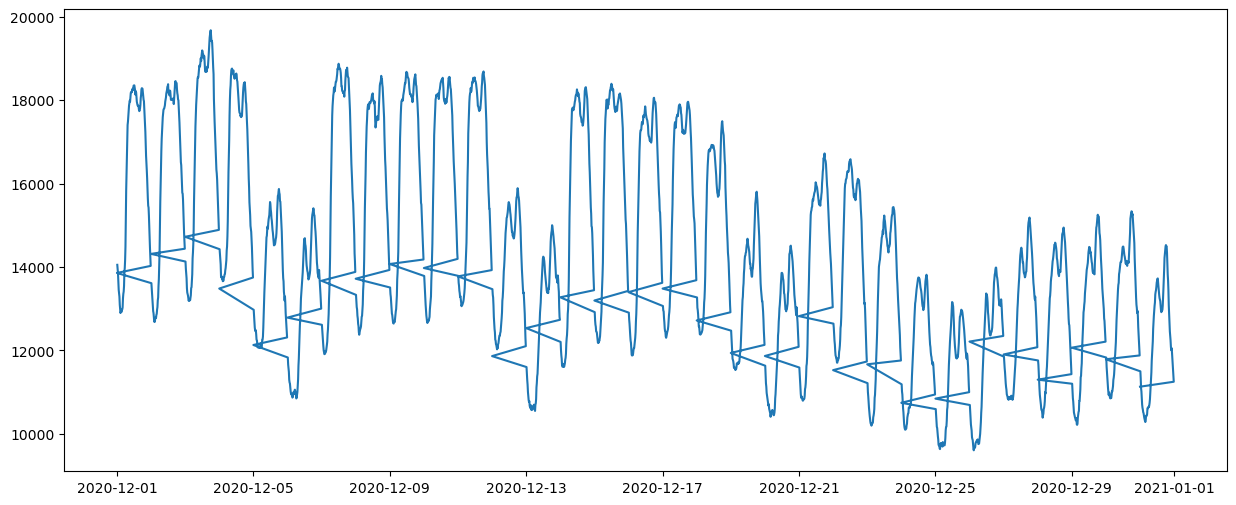

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(df_fill[(df_fill.index.year == 2020) & (df_fill.index.month == 12)]["gesamt"])
# plt.plot(df_fill[(df_fill.index.year > 2018) & (df_fill.index.year < 2021)]["gesamt"])
plt.show()

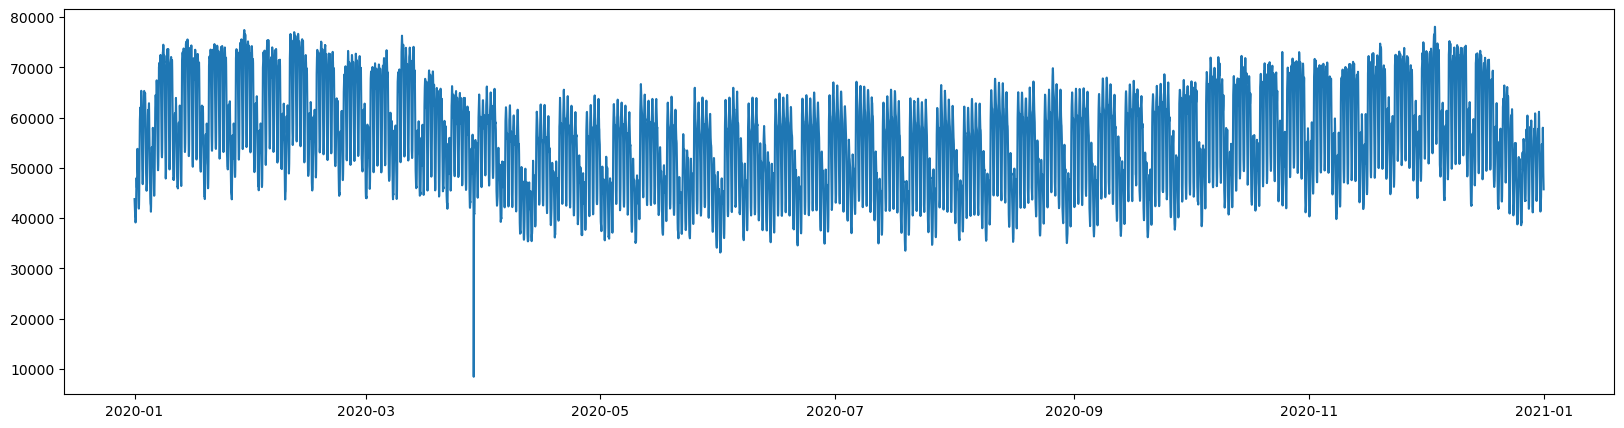

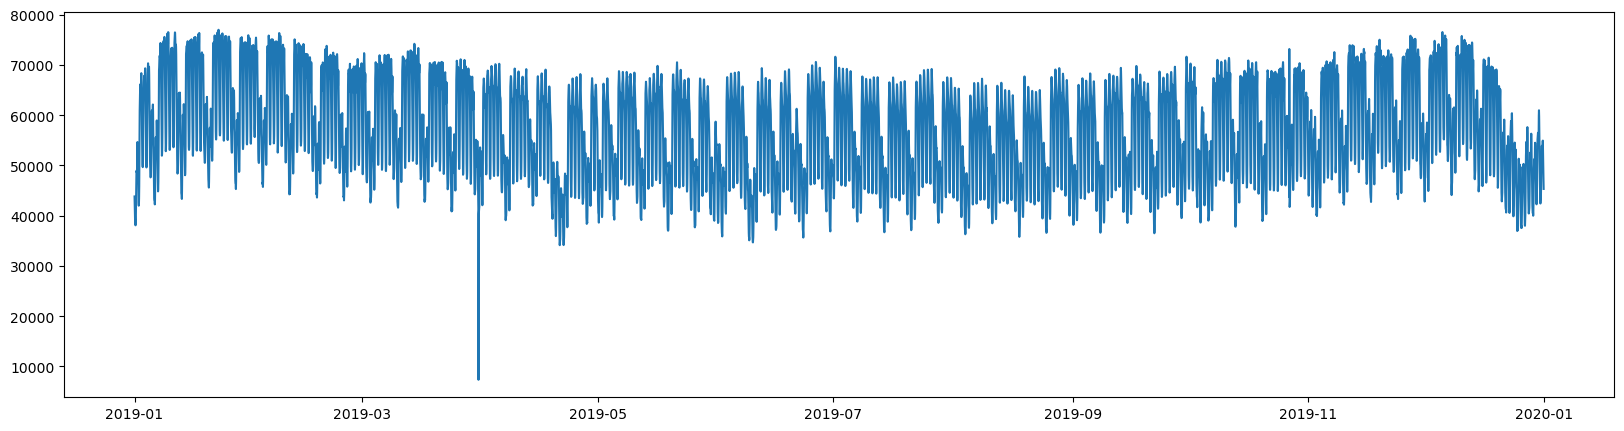

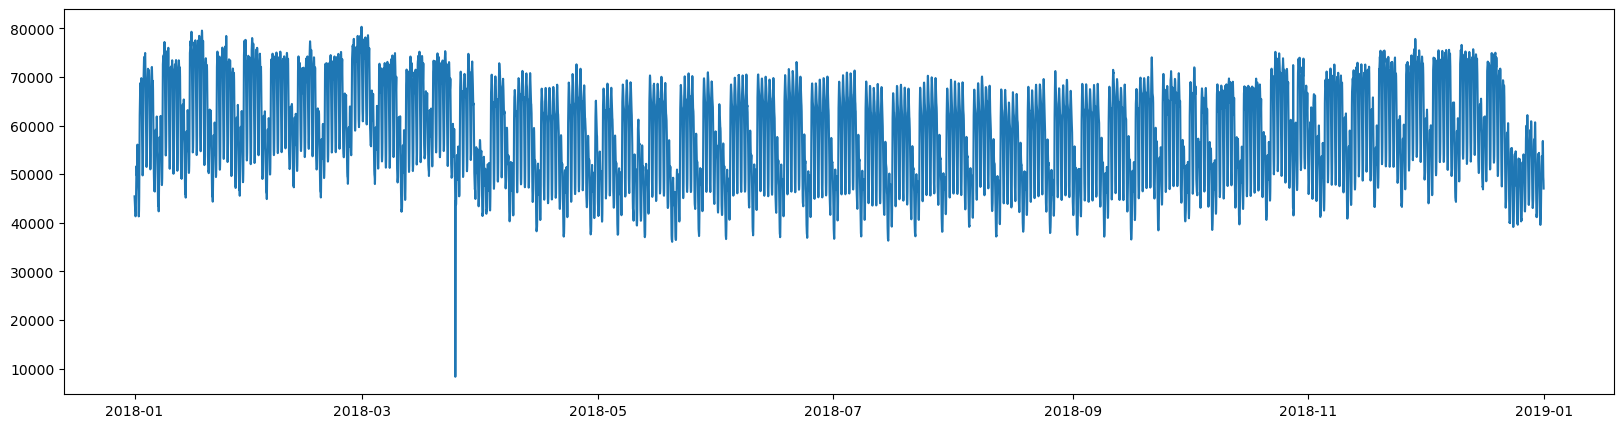

In [15]:
# plt.figure(figsize=(20, 5))

# for yr in np.unique(df_hourly.index.year):
#     df_yr = df_hourly[(df_hourly.index.year == yr)]
#     x = np.arange(0, df_yr.shape[0])
#     plt.plot(x, df_yr["gesamt"], color='grey', lw=0.5, alpha=0.1)

# df_yr_avg = df_hourly.groupby([df_hourly.index.month, df_hourly.index.day, df_hourly.index.hour])['gesamt'].mean()
# x = np.arange(0, df_yr_avg.shape[0])
# plt.plot(x, df_yr_avg, color='red', lw=1, alpha=0.5)
# plt.show()

plt.figure(figsize=(20, 5))
plt.plot(df_hourly[(df_hourly.index.year == 2020)]["gesamt"])
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(df_hourly[(df_hourly.index.year == 2019)]["gesamt"])
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(df_hourly[(df_hourly.index.year == 2018)]["gesamt"])
plt.show()

In [16]:
np.argmin(df_hourly[(df_hourly.index.year == 2020)]["gesamt"][2000:2500])

114

In [17]:
df_hourly[(df_hourly.index.year == 2020)]["gesamt"][2100:2150]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/hy/gj03fhbj5wg417124pmms5t80000gn/T/ipykernel_77584/1382366037.py", line 1, in <module>
    df_hourly[(df_hourly.index.year == 2020)]["gesamt"][2100:2150]
  File "/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/IPython/core/displayhook.py", line 262, in __call__
    format_dict, md_dict = self.compute_format_data(result)
  File "/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/IPython/core/displayhook.py", line 151, in compute_format_data
    return self.shell.display_formatter.format(result)
  File "/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/decorator.py", line 232, in fun
    return call

TypeError: object of type 'NoneType' has no len()

In [ ]:
plt.figure(figsize=(15, 6))
# plt.plot(df_fill[(df_fill.index.year == 2020) & (df_fill.index.month == 12)]["gesamt"])
plt.plot(df_fill[(df_fill.index.year > 2018) & (df_fill.index.year < 2021)]["gesamt"])
plt.show()

---

Lead times are

In [ ]:
horizons = [36, 40, 44, 60, 64, 68] #[24 + 12*i for i in range(5)]
horizons

In [ ]:
def get_date_from_horizon(last_ts, horizon):
    
    """ adds horizon hours to timeindex last_ts """
    
    return last_ts + pd.DateOffset(hours = horizon)

In [ ]:
LAST_IDX = -1
LAST_DATE = df.iloc[LAST_IDX].name
print(LAST_DATE)

Get time and date that correspond to the lead times (starting at the last observation in our data which should be the respective thursday 0:00)  
*Attention*: if the last timestamp in the data is not thursday 0:00, you have to adjust your lead times accordingly

In [ ]:
horizon_date = [get_date_from_horizon(LAST_DATE, h) for h in horizons]
horizon_date

quantile levels

In [ ]:
tau = [.025, .25, .5, .75, .975]

In [ ]:
#rows correspond to horizon, columns to quantile level
pred_baseline = np.zeros((6,5))

In [ ]:
last_t = 100

for i,d in enumerate(horizon_date):
    
    # Extract the weekday and hour from the date 'd'
    # (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) 
    weekday = d.weekday()
    hour = d.hour
    
    # Create a temporary DataFrame 'df_tmp' 
    # by selecting the first 'LAST_IDX' rows from the original DataFrame 'df'
    df_tmp = df_hourly.iloc[:LAST_IDX]
    
    # Define a condition 'cond' to filter rows in 'df_tmp' based on the weekday and time of day
    cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())
    
    # Calculate the quantiles of the 'gesamt' column in 'df_tmp' that meet the 'cond' condition
    # The quantiles are calculated for each 'tau' value, and the results are stored in 'pred_baseline'
    pred_baseline[i, :] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau)


In [ ]:
pred_baseline = pred_baseline / 1000

In [ ]:
pred_baseline

Visually check if quantiles make sense

In [ ]:
x = horizons
quantiles = tau
# tau = [.025, .25, .5, .75, .975]

colors = ['lightblue', 'blue', 'blue', 'lightblue']

# Creating colored intervals between quantiles
for i in range(len(quantiles) - 1):
    plt.fill_between(
        horizons,
        pred_baseline[:, i],
        pred_baseline[:, i + 1],
        alpha=0.2,  # Adjust transparency as needed
        color=colors[i],
        label=f'Quantile {quantiles[i]} - {quantiles[i + 1]}',
    )

_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

In [ ]:
from datetime import datetime
date_str = datetime.today().strftime('%Y-%m-%d')

In [ ]:
df_sub = pd.DataFrame({
    
    "forecast_date": date_str, 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]

})

df_sub

In [ ]:
for row_to_check in range(df_sub.shape[0]):
    row_values = df_sub.iloc[row_to_check, 3:].values
    is_ordered = all(row_values[i] <= row_values[i + 1] for i in range(len(row_values) - 1))
    print(is_ordered)

In [ ]:
#need to change this
PATH = "/Users/yanting/OneDrive/Desktop/23_24 WS (Master)/PTSFC/Submissions"

date_str = datetime.today().strftime('%Y_%m_%d')

df_sub.to_csv(PATH+"/"+date_str+"_power_benchmark.csv",index=False)